#### This notebook is relevant for the validation of the features. Figure 4 in the manuscript. 

In [1]:
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [2]:
# Define functions

def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], max_depth=para['max_depth'], n_estimators=para['n_estimators'])
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)

In [3]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 
GE = pd.read_csv("../../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")

#Load features from features that predict drug response, regulatory graph and house keeping genes
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
#KG_expr_resp = pd.read_csv("../../../../Manuscript/Supplemental_Tables/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_expr_resp = pd.read_csv("./Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")

KG_reg = pd.read_csv("KG_regulatory_graph_Mar1_2023.csv")


# Load testing data from BeatAML wave 3 and 4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")

In [4]:
#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list = (list(GE.index))
sample_list = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [5]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"
res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")

# Selection of the second neighbors
#res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")
print(len(selected_genes))

44


In [6]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [7]:
new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg)

new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg)

In [8]:
# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
df_sele = df_sele.dropna()
df_sele.head(3)
df_sele.shape

(186, 850)

In [9]:
Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
df_sele__wave3 = df_sele__wave3.dropna()
df_sele__wave3.head(3)
df_sele__wave3.shape


(367, 850)

In [10]:
df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_65963/1949196757.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]


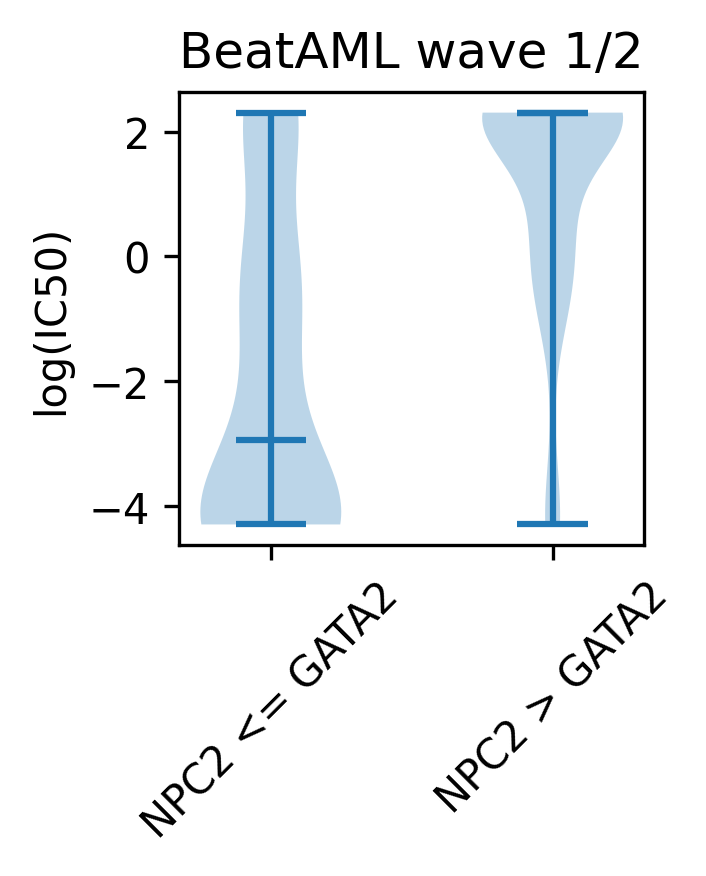

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_65963/303493730.py:18: DeprecationWarning: Please use `ranksums` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ranksums(arr1, arr2)


RanksumsResult(statistic=-7.181511597011541, pvalue=6.894483472163706e-13)

In [12]:
Feature = "NPC2-GATA2"


arr1 = df_sele.loc[df_sele[Feature] == 0,]['ic50']
arr2  = df_sele.loc[df_sele[Feature] == 1,]['ic50']

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(arr1), np.log(arr2)], showmedians=True)
plt.ylabel('log(IC50)')
plt.title("BeatAML wave 1/2")
plt.xticks([1, 2], 
           [' <= '.join([Feature.split("-")[0], Feature.split('-')[1]]),  ' > '.join([Feature.split("-")[0], Feature.split('-')[1]])], 
           rotation = 45)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
stats.ranksums(arr1, arr2)

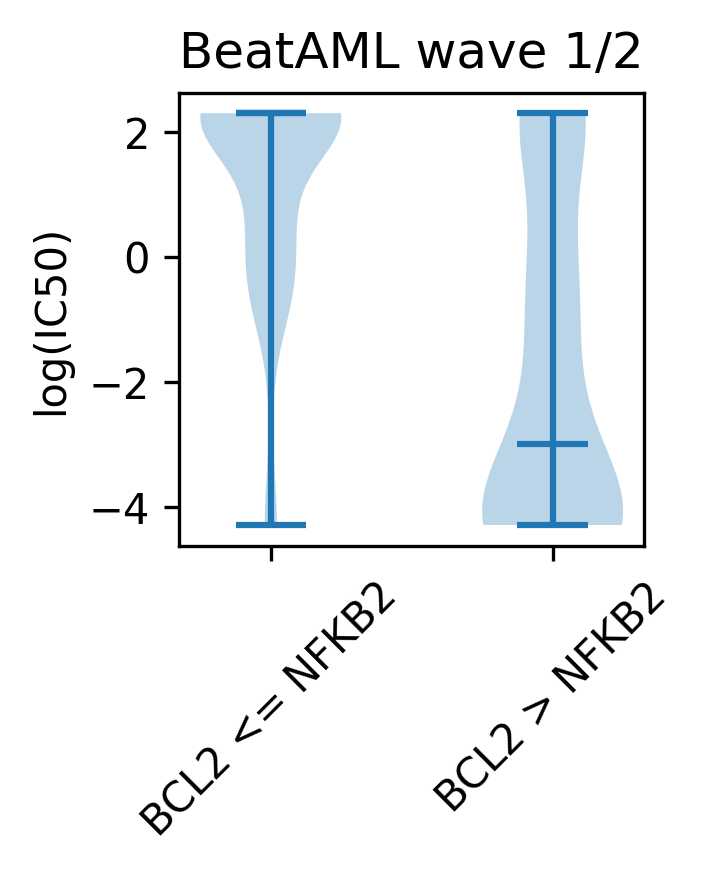

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_65963/570438005.py:19: DeprecationWarning: Please use `ranksums` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ranksums(arr1, arr2)


RanksumsResult(statistic=6.759398519817259, pvalue=1.3856577326048966e-11)

In [11]:
Feature = "NPC2-GATA2"
#Feature = "FGD4-MIR4519"
Feature = "BCL2-NFKB2"

arr1 = df_sele.loc[df_sele[Feature] == 0,]['ic50']
arr2  = df_sele.loc[df_sele[Feature] == 1,]['ic50']

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(arr1), np.log(arr2)], showmedians=True)
plt.ylabel('log(IC50)')
plt.title("BeatAML wave 1/2")
plt.xticks([1, 2], 
           [' <= '.join([Feature.split("-")[0], Feature.split('-')[1]]),  ' > '.join([Feature.split("-")[0], Feature.split('-')[1]])], 
           rotation = 45)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
stats.ranksums(arr1, arr2)



In [13]:
df_sele.loc[:,['NPC2-GATA2','BCL2-NFKB2']]
feature1 = "NPC2-GATA2"
feature2 = "BCL2-NFKB2"
I_0_0 = list(df_sele.loc[(df_sele[feature1] == 0) & (df_sele[feature2] == 0),].index)
I_0_1 = list(df_sele.loc[(df_sele[feature1] == 0) & (df_sele[feature2] == 1),].index)
I_1_0 = list(df_sele.loc[(df_sele[feature1] == 1) & (df_sele[feature2] == 0),].index)
I_1_1 = list(df_sele.loc[(df_sele[feature1] == 1) & (df_sele[feature2] == 1),].index)

19
63
81
23


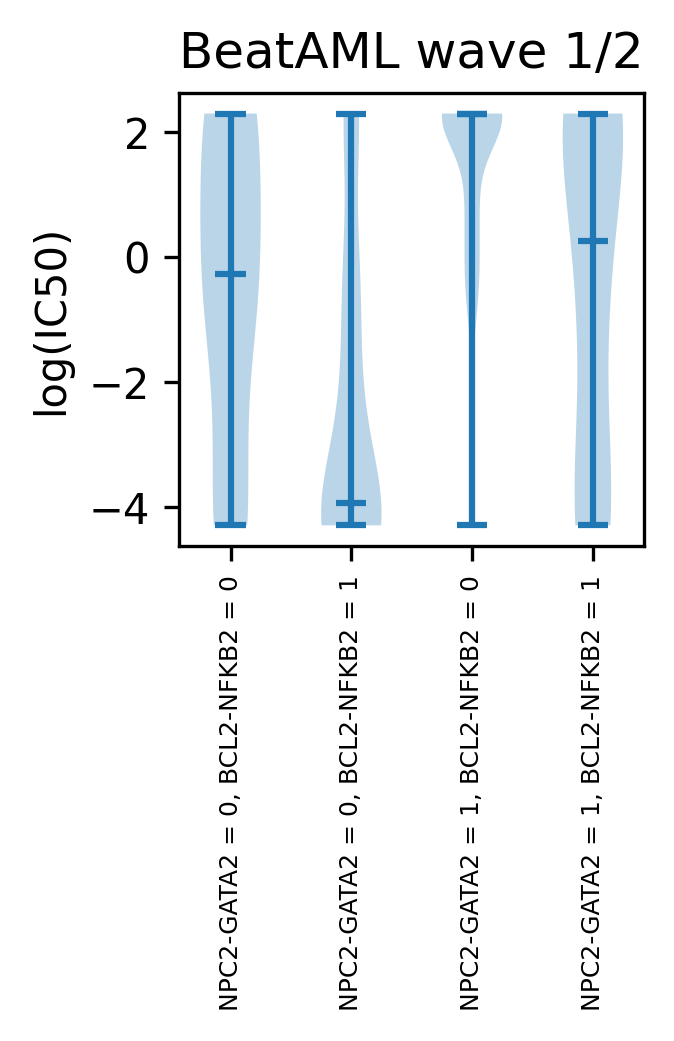

In [14]:

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(df_sele.loc[I_0_0,:]['ic50'].values),
                np.log(df_sele.loc[I_0_1,:]['ic50'].values),
                np.log(df_sele.loc[I_1_0,:]['ic50'].values),
                np.log(df_sele.loc[I_1_1,:]['ic50'].values)],
                showmedians=True)

print(len(I_0_0))
print(len(I_0_1))
print(len(I_1_0))
print(len(I_1_1))

plt.ylabel('log(IC50)')
plt.title("BeatAML wave 1/2")
plt.xticks([1, 2,3,4], 
           [feature1 + " = 0, " + feature2 + " = 0", 
            feature1 + " = 0, " + feature2 + " = 1",
              feature1 + " = 1, " + feature2 + " = 0", 
              feature1 + " = 1, " + feature2 + " = 1"],
           rotation = 90, fontsize = 6)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
#stats.ranksums(arr1, arr2)


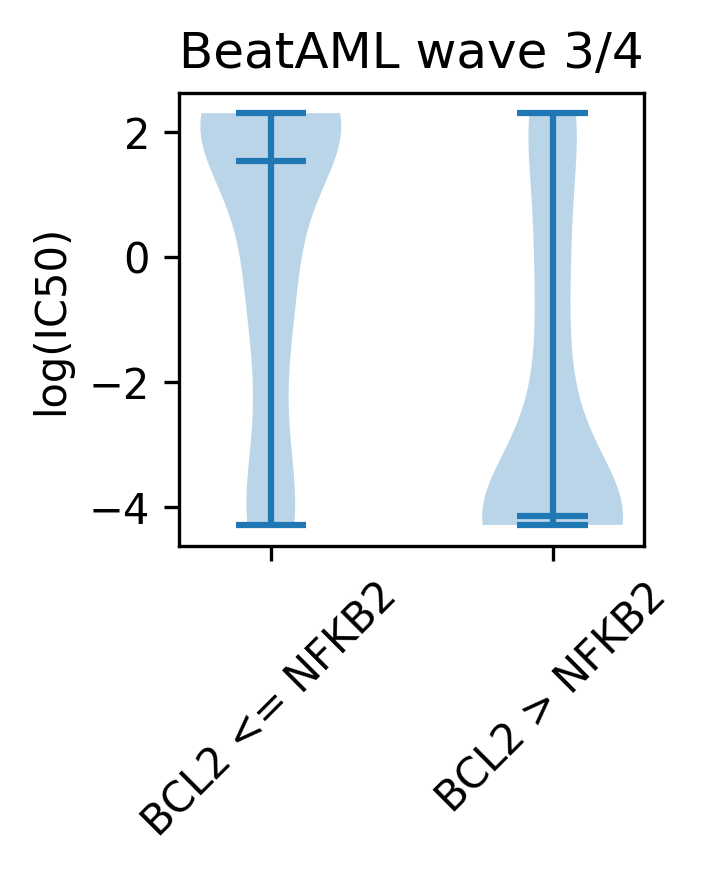

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_65963/2735900170.py:19: DeprecationWarning: Please use `ranksums` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ranksums(arr1, arr2)


RanksumsResult(statistic=5.6352788325592185, pvalue=1.7477531711984048e-08)

In [15]:
Feature = "NPC2-GATA2"
#Feature = "FGD4-MIR4519"
Feature = "BCL2-NFKB2"

arr1 = df_sele__wave3_new.loc[df_sele__wave3_new[Feature] == 0,]['ic50']
arr2  = df_sele__wave3_new.loc[df_sele__wave3_new[Feature] == 1,]['ic50']

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(arr1), np.log(arr2)], showmedians=True)
plt.ylabel('log(IC50)')
plt.title("BeatAML wave 3/4")
plt.xticks([1, 2], 
           [' <= '.join([Feature.split("-")[0], Feature.split('-')[1]]),  ' > '.join([Feature.split("-")[0], Feature.split('-')[1]])],
           rotation = 45)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
stats.ranksums(arr1, arr2)



In [16]:
feature1 = "NPC2-GATA2"
feature2 = "BCL2-NFKB2"
I_0_0 = list(df_sele__wave3_new.loc[(df_sele__wave3_new[feature1] == 0) & (df_sele__wave3_new[feature2] == 0),].index)
I_0_1 = list(df_sele__wave3_new.loc[(df_sele__wave3_new[feature1] == 0) & (df_sele__wave3_new[feature2] == 1),].index)
I_1_0 = list(df_sele__wave3_new.loc[(df_sele__wave3_new[feature1] == 1) & (df_sele__wave3_new[feature2] == 0),].index)
I_1_1 = list(df_sele__wave3_new.loc[(df_sele__wave3_new[feature1] == 1) & (df_sele__wave3_new[feature2] == 1),].index)

24
67
64
27


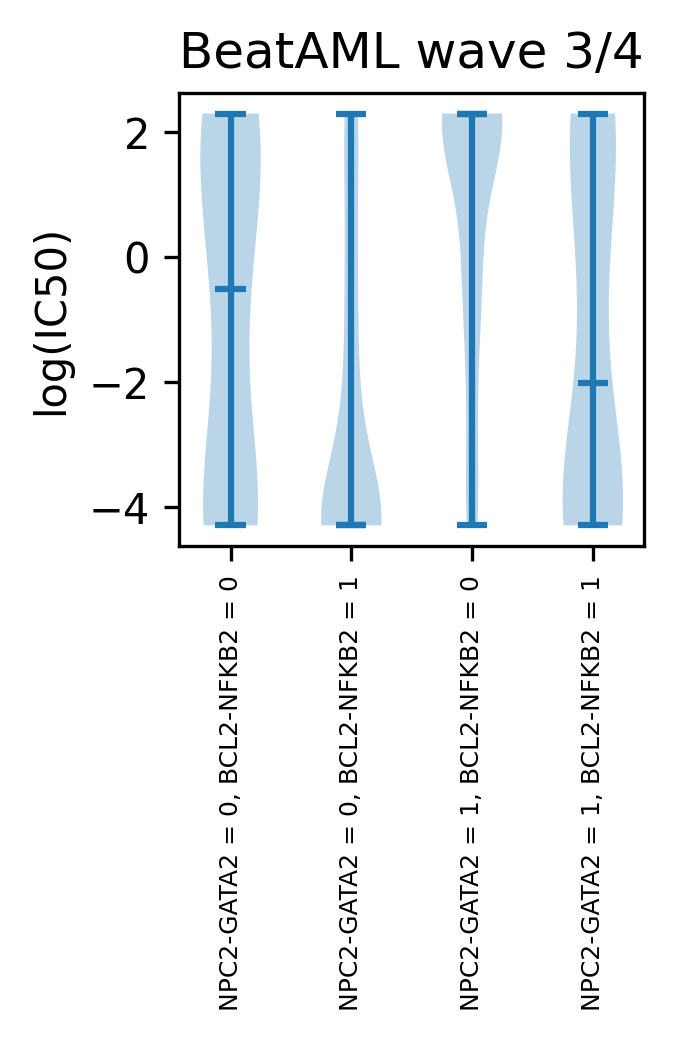

In [17]:

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(df_sele__wave3_new.loc[I_0_0,:]['ic50'].values),
                np.log(df_sele__wave3_new.loc[I_0_1,:]['ic50'].values),
                np.log(df_sele__wave3_new.loc[I_1_0,:]['ic50'].values),
                np.log(df_sele__wave3_new.loc[I_1_1,:]['ic50'].values)],
                showmedians=True)

print(len(I_0_0))
print(len(I_0_1))
print(len(I_1_0))
print(len(I_1_1))

plt.ylabel('log(IC50)')
plt.title("BeatAML wave 3/4")
plt.xticks([1, 2,3,4], 
           [feature1 + " = 0, " + feature2 + " = 0", 
            feature1 + " = 0, " + feature2 + " = 1",
              feature1 + " = 1, " + feature2 + " = 0", 
              feature1 + " = 1, " + feature2 + " = 1"],
           rotation = 90, fontsize = 6)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
#stats.ranksums(arr1, arr2)


0.328125

In [18]:
# read drug response data from FIMM
Drug_response_FIMM = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/FIMM/File_3.2_Drug_response_DSS_sDSS_164S_17Healthy.xlsx - Table 7.csv")
Venetoclax_FIMM = Drug_response_FIMM.loc[Drug_response_FIMM['Chemical_compound'] == "Venetoclax"]

CPM_FIMM = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/FIMM/File_7_RNA_seq_CPM_163S_4Healthy.csv", index_col="Unnamed: 0")
mut_FIMM = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/FIMM/File_6_Binary_mutation_225S_57G.xlsx - Sheet1.csv", index_col="Unnamed: 0")
mut_FIMM = mut_FIMM.transpose()
cli_FIMM  = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/FIMM/File_1.1_Clinical_summary_186_Patients.xlsx - Clinical summary.csv", index_col = "Patient_ID")

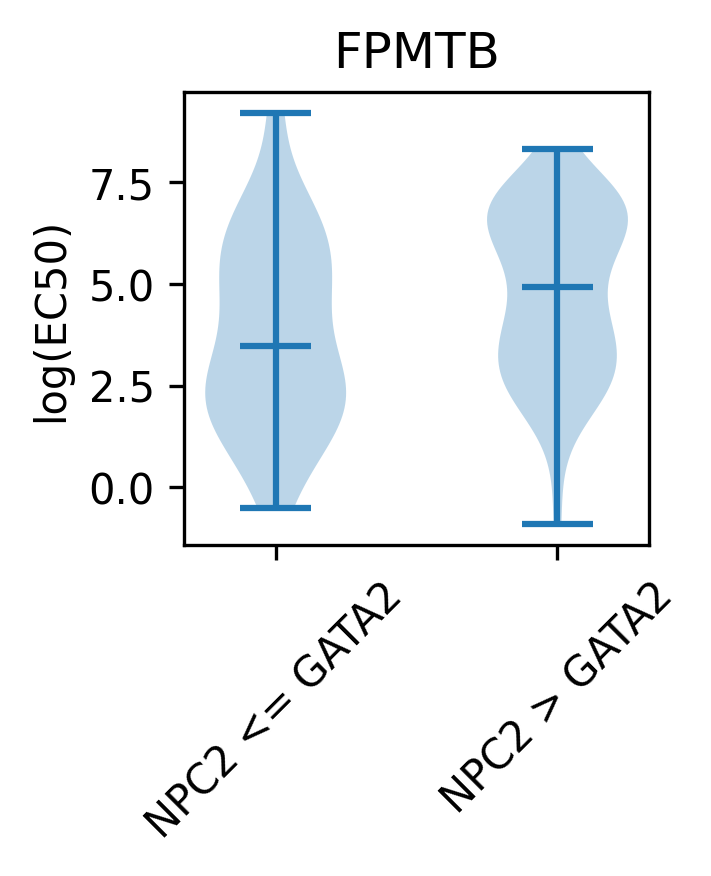

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_65963/88878403.py:46: DeprecationWarning: Please use `ranksums` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ranksums(arr1, arr2)


RanksumsResult(statistic=-2.5567917438336285, pvalue=0.010564244281353706)

In [19]:
#input
Feature = "NPC2-GATA2"
NPC2_GATA2_df = CPM_FIMM.loc[["ENSG00000119655","ENSG00000179348"],:]


#Feature = "BCL2-NFKB2"
#NPC2_GATA2_df = CPM_FIMM.loc[["ENSG00000171791","ENSG00000077150"],:]


NPC2_GATA2_df.index = [Feature.split("-")[0],Feature.split("-")[1]]

# exclude healthy samples
NPC2_GATA2_df = NPC2_GATA2_df.loc[:,NPC2_GATA2_df.columns.str.contains("AML")]

# exclude healthy samples in Venetoclax_FIMM
Venetoclax_FIMM = Venetoclax_FIMM.loc[Venetoclax_FIMM['Sample_ID'].str.contains("AML"),:]
#Venetoclax_FIMM


# substrate NPC2 with GATA2
new_feature_df_t_FIMM = formating_relative_expression(NPC2_GATA2_df,[Feature.split("-")[0]],[Feature.split("-")[1]], KG_reg)
new_feature_df_t_FIMM.columns = [Feature]

#Feature = "FGD4-MIR4519"

arr1 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(new_feature_df_t_FIMM.loc[new_feature_df_t_FIMM[Feature] == 0,].index)]['EC50']
arr2 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(new_feature_df_t_FIMM.loc[new_feature_df_t_FIMM[Feature] == 1,].index)]['EC50']


#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))
plt.violinplot([np.log(arr1), np.log(arr2)], showmedians=True)
plt.ylabel('log(EC50)')
plt.title("FPMTB")
plt.xticks([1, 2], 
           [' <= '.join([Feature.split("-")[0], Feature.split('-')[1]]),  ' > '.join([Feature.split("-")[0], Feature.split('-')[1]])],
           rotation = 45)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
stats.ranksums(arr1, arr2)


In [21]:

#input
Feature1 = "NPC2-GATA2"
NPC2_GATA2_df = CPM_FIMM.loc[["ENSG00000119655","ENSG00000179348"],:]

Feature2 = "BCL2-NFKB2"
BCL2_NFKB2_df = CPM_FIMM.loc[["ENSG00000171791","ENSG00000077150"],:]

#Feature = "FGD4-MIR4519" #MIR4519 is not measured in FIMM dataset
#NPC2_GATA2_dfCPM_FIMM.loc[["ENSG00000139132","ENSG00000265991"]]

#Feature = "BCL2-FOXO1"
#NPC2_GATA2_df = CPM_FIMM.loc[["ENSG00000171791","ENSG00000150907"]]

NPC2_GATA2_df.index = [Feature1.split("-")[0],Feature1.split("-")[1]]
BCL2_NFKB2_df.index = [Feature2.split("-")[0],Feature2.split("-")[1]]

merged_df = pd.concat([NPC2_GATA2_df,BCL2_NFKB2_df], axis = 1)

# exclude healthy samples
merged_df = merged_df.loc[:,merged_df.columns.str.contains("AML")]

# exclude healthy samples in Venetoclax_FIMM
Venetoclax_FIMM = Venetoclax_FIMM.loc[Venetoclax_FIMM['Sample_ID'].str.contains("AML"),:]
#Venetoclax_FIMM


# substrate NPC2 with GATA2
new_feature_df_t_FIMM1 = formating_relative_expression(merged_df,[Feature1.split("-")[0]],[Feature1.split("-")[1]], KG_reg)
new_feature_df_t_FIMM2 = formating_relative_expression(merged_df,[Feature2.split("-")[0]],[Feature2.split("-")[1]], KG_reg)

new_feature_df_t_FIMM = pd.concat([new_feature_df_t_FIMM1,new_feature_df_t_FIMM2], axis = 1)

new_feature_df_t_FIMM.columns = [Feature1,Feature2]

I_0_0 = list(new_feature_df_t_FIMM.loc[(new_feature_df_t_FIMM[feature1] == 0) & (new_feature_df_t_FIMM[feature2] == 0),].index)
I_0_1 = list(new_feature_df_t_FIMM.loc[(new_feature_df_t_FIMM[feature1] == 0) & (new_feature_df_t_FIMM[feature2] == 1),].index)
I_1_0 = list(new_feature_df_t_FIMM.loc[(new_feature_df_t_FIMM[feature1] == 1) & (new_feature_df_t_FIMM[feature2] == 0),].index)
I_1_1 = list(new_feature_df_t_FIMM.loc[(new_feature_df_t_FIMM[feature1] == 1) & (new_feature_df_t_FIMM[feature2] == 1),].index)

In [157]:
Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(I_1_1),:]['EC50'].values

array([], dtype=float64)

118
129
79
0


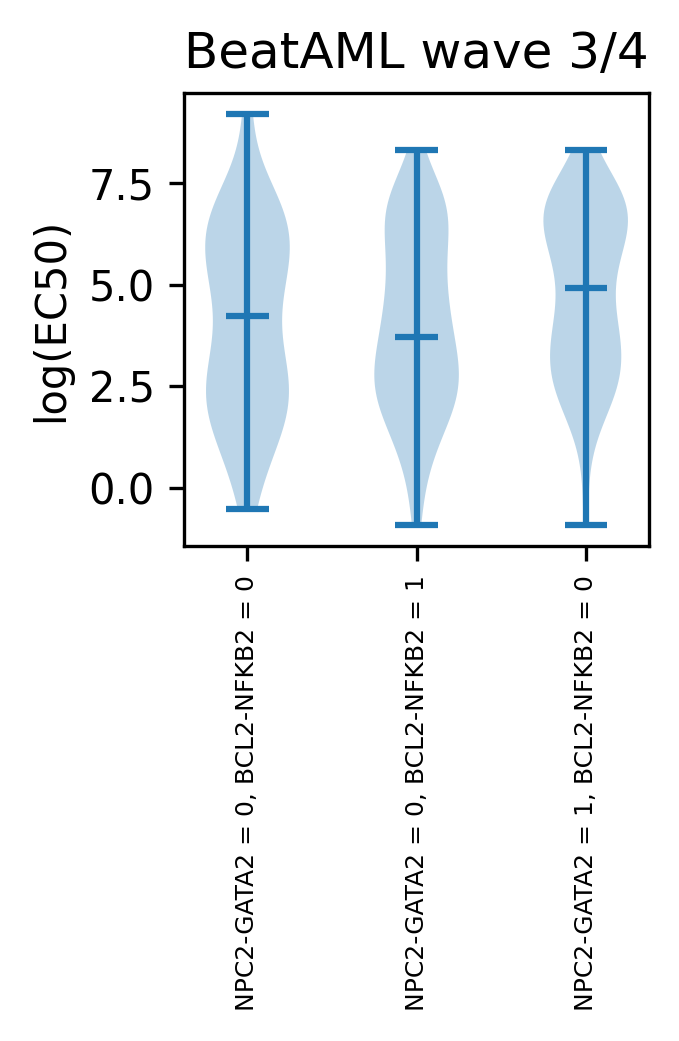

In [22]:

#plot a violin plot for arr1 and arr2
plt.figure(dpi = 300, figsize = (2, 2))

arr1 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(I_0_0),:]['EC50'].values
arr2 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(I_0_1),:]['EC50'].values
arr3 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(I_1_0),:]['EC50'].values
arr4 = Venetoclax_FIMM.loc[Venetoclax_FIMM["Sample_ID"].isin(I_1_1),:]['EC50'].values


plt.violinplot([np.log(arr1),np.log(arr2),np.log(arr3)],
                showmedians=True)

print(len(I_0_0))
print(len(I_0_1))
print(len(I_1_0))
print(len(I_1_1))

plt.ylabel('log(EC50)')
plt.title("BeatAML wave 3/4")
plt.xticks([1, 2,3], 
           [feature1 + " = 0, " + feature2 + " = 0", 
            feature1 + " = 0, " + feature2 + " = 1",
              feature1 + " = 1, " + feature2 + " = 0", 
              #feature1 + " = 1, " + feature2 + " = 1"
              ],
           rotation = 90, fontsize = 6)
plt.show()

# wilcoxon rank sum test for arr1 and arr2
#stats.ranksums(arr1, arr2)
